<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [1]:
# import os
# if not os.path.exists('GEOMAR-DeepLearning'):
#     print(f'GEOMAR-DeepLearning does not exist')
#     !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt
# else:
#     print(f'GEOMAR-DeepLearning exists')
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt

## Import Libaries

In [2]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
import folium
from tqdm import tqdm
from utils.OpenMeteoWeather import OpenMeteoWeather

from datetime import datetime
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

/home/marco/venv/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Training Data

In [3]:
START_DATE = '2025-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    
    "minimum_longitude":9.10,
    "maximum_longitude":30.20,
    "minimum_latitude":53.10,
    "maximum_latitude":65.00,

    # "minimum_longitude":9.85083510071235,
    # "maximum_longitude":10.926709174713364,
    # "minimum_latitude":54.25206332481298,
    # "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [4]:
# Download Data
minimum_latitude = BBOX['minimum_latitude']
maximum_latitude = BBOX['maximum_latitude']
minimum_longitude = BBOX['minimum_longitude']
maximum_longitude = BBOX['maximum_longitude']

copernicus = AdvancedCopernicus()

latitudes = np.linspace(minimum_latitude, maximum_latitude, 10)
longitudes = np.linspace(minimum_longitude, maximum_longitude, 10)

In [5]:
# zip latitudes and longitudes
coordinates = set([(float(lat), float(lon)) for lat in latitudes for lon in longitudes])

# plot the coordinates to folium
folium_map = folium.Map(location=[minimum_latitude, minimum_longitude], zoom_start=4)
for lat, lon in coordinates:
    folium.CircleMarker(location=[lat, lon], radius=5, color='red').add_to(folium_map)
folium_map

### Ocean Data

In [6]:


# Calculate Radius
radius = 0.001

variables = ["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"]
df_ocean = pd.DataFrame()
for lat, lon in tqdm(coordinates, total=len(coordinates)):
    print(lat, lon)
    file = f'output_filename_{lat, lon}.nc'

    if file in os.listdir():
        data = xr.open_dataset(file)
        data = data.to_dataframe().reset_index()
        df_ocean = pd.concat([df_ocean, data], axis=0)
    else:
        data = copernicus.get_subset(
            dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
            dataset_version="202411",
            variables=variables,
            minimum_longitude=lon-radius,
            maximum_longitude=lon+radius,
            minimum_latitude=lat-radius,
            maximum_latitude=lat+radius,
    
            start_datetime=START_DATE,
            end_datetime=END_DATE,
            minimum_depth=0.5016462206840515,
            maximum_depth=0.5016462206840515,
            coordinates_selection_method="strict-inside",
            disable_progress_bar=False,
            output_filename=file,
            delete_file=False)
    
    
    
        data = data.to_dataframe().reset_index()
        df_ocean = pd.concat([df_ocean, data], axis=0)

print(df_ocean.info())
display(df_ocean.head())

  0%|          | 0/100 [00:00<?, ?it/s]

53.1 18.477777777777778


  2%|▏         | 2/100 [00:00<00:17,  5.58it/s]

57.06666666666667 16.133333333333333
54.422222222222224 18.477777777777778


  4%|▍         | 4/100 [00:00<00:14,  6.83it/s]

61.03333333333333 20.822222222222223
55.74444444444445 18.477777777777778


  6%|▌         | 6/100 [00:00<00:13,  7.23it/s]

57.06666666666667 11.444444444444445
62.355555555555554 20.822222222222223


  8%|▊         | 8/100 [00:01<00:12,  7.66it/s]

61.03333333333333 9.1
65.0 27.855555555555554


 10%|█         | 10/100 [00:01<00:11,  7.62it/s]

58.388888888888886 13.788888888888888
63.67777777777778 20.822222222222223


 11%|█         | 11/100 [00:01<00:14,  6.35it/s]

65.0 30.2


 12%|█▏        | 12/100 [00:01<00:15,  5.68it/s]

58.388888888888886 16.133333333333333


 13%|█▎        | 13/100 [00:02<00:16,  5.22it/s]

62.355555555555554 9.1


 15%|█▌        | 15/100 [00:02<00:16,  5.12it/s]

59.71111111111111 13.788888888888888
59.71111111111111 16.133333333333333


 17%|█▋        | 17/100 [00:02<00:15,  5.53it/s]

61.03333333333333 25.511111111111113
63.67777777777778 9.1


 19%|█▉        | 19/100 [00:03<00:13,  5.88it/s]

53.1 23.166666666666664
62.355555555555554 25.511111111111113


 21%|██        | 21/100 [00:03<00:12,  6.52it/s]

54.422222222222224 23.166666666666664
58.388888888888886 18.477777777777778


 23%|██▎       | 23/100 [00:03<00:12,  6.07it/s]

63.67777777777778 25.511111111111113
55.74444444444445 23.166666666666664


 25%|██▌       | 25/100 [00:04<00:13,  5.69it/s]

59.71111111111111 18.477777777777778
65.0 16.133333333333333


 27%|██▋       | 27/100 [00:04<00:13,  5.48it/s]

61.03333333333333 27.855555555555554
61.03333333333333 30.2


 29%|██▉       | 29/100 [00:04<00:12,  5.50it/s]

62.355555555555554 27.855555555555554
65.0 11.444444444444445


 30%|███       | 30/100 [00:05<00:13,  5.31it/s]

62.355555555555554 30.2


 32%|███▏      | 32/100 [00:05<00:13,  5.17it/s]

63.67777777777778 27.855555555555554
57.06666666666667 13.788888888888888


 33%|███▎      | 33/100 [00:05<00:12,  5.43it/s]

58.388888888888886 23.166666666666664


 35%|███▌      | 35/100 [00:06<00:12,  5.30it/s]

63.67777777777778 30.2
59.71111111111111 23.166666666666664


 37%|███▋      | 37/100 [00:06<00:10,  5.95it/s]

55.74444444444445 30.2
53.1 20.822222222222223


 38%|███▊      | 38/100 [00:06<00:10,  6.15it/s]

57.06666666666667 18.477777777777778


 40%|████      | 40/100 [00:06<00:10,  5.51it/s]

54.422222222222224 20.822222222222223
61.03333333333333 16.133333333333333


 42%|████▏     | 42/100 [00:07<00:10,  5.62it/s]

53.1 9.1
55.74444444444445 20.822222222222223


 44%|████▍     | 44/100 [00:07<00:08,  6.27it/s]

62.355555555555554 16.133333333333333
54.422222222222224 9.1


 46%|████▌     | 46/100 [00:07<00:08,  6.11it/s]

61.03333333333333 11.444444444444445
63.67777777777778 16.133333333333333


 48%|████▊     | 48/100 [00:08<00:08,  6.29it/s]

53.1 25.511111111111113
55.74444444444445 9.1


 50%|█████     | 50/100 [00:08<00:07,  6.60it/s]

62.355555555555554 11.444444444444445
54.422222222222224 25.511111111111113


 52%|█████▏    | 52/100 [00:08<00:07,  6.84it/s]

63.67777777777778 11.444444444444445
55.74444444444445 25.511111111111113


 54%|█████▍    | 54/100 [00:09<00:06,  7.15it/s]

57.06666666666667 23.166666666666664
65.0 13.788888888888888


 56%|█████▌    | 56/100 [00:09<00:06,  7.08it/s]

58.388888888888886 20.822222222222223
59.71111111111111 20.822222222222223


 58%|█████▊    | 58/100 [00:09<00:06,  6.79it/s]

53.1 27.855555555555554
53.1 30.2


 60%|██████    | 60/100 [00:09<00:06,  6.57it/s]

59.71111111111111 9.1
65.0 18.477777777777778


 62%|██████▏   | 62/100 [00:10<00:05,  6.47it/s]

54.422222222222224 27.855555555555554
54.422222222222224 30.2


 64%|██████▍   | 64/100 [00:10<00:05,  6.79it/s]

58.388888888888886 25.511111111111113
55.74444444444445 27.855555555555554


 66%|██████▌   | 66/100 [00:10<00:05,  6.80it/s]

59.71111111111111 25.511111111111113
61.03333333333333 13.788888888888888


 68%|██████▊   | 68/100 [00:11<00:04,  6.82it/s]

62.355555555555554 13.788888888888888
63.67777777777778 13.788888888888888


 70%|███████   | 70/100 [00:11<00:04,  6.65it/s]

53.1 16.133333333333333
65.0 23.166666666666664


 72%|███████▏  | 72/100 [00:11<00:04,  6.36it/s]

57.06666666666667 20.822222222222223
58.388888888888886 30.2


 74%|███████▍  | 74/100 [00:12<00:04,  6.31it/s]

54.422222222222224 16.133333333333333
61.03333333333333 18.477777777777778


 76%|███████▌  | 76/100 [00:12<00:03,  6.86it/s]

53.1 11.444444444444445
59.71111111111111 30.2


 78%|███████▊  | 78/100 [00:12<00:03,  7.24it/s]

55.74444444444445 16.133333333333333
57.06666666666667 9.1


 80%|████████  | 80/100 [00:12<00:02,  7.19it/s]

62.355555555555554 18.477777777777778
54.422222222222224 11.444444444444445


 82%|████████▏ | 82/100 [00:13<00:02,  7.35it/s]

63.67777777777778 18.477777777777778
55.74444444444445 11.444444444444445


 84%|████████▍ | 84/100 [00:13<00:02,  7.59it/s]

57.06666666666667 25.511111111111113
58.388888888888886 9.1


 86%|████████▌ | 86/100 [00:13<00:01,  7.67it/s]

61.03333333333333 23.166666666666664
62.355555555555554 23.166666666666664


 88%|████████▊ | 88/100 [00:14<00:02,  5.77it/s]

58.388888888888886 11.444444444444445
63.67777777777778 23.166666666666664


 90%|█████████ | 90/100 [00:14<00:01,  5.44it/s]

57.06666666666667 27.855555555555554
59.71111111111111 11.444444444444445


 91%|█████████ | 91/100 [00:14<00:01,  5.12it/s]

57.06666666666667 30.2


 92%|█████████▏| 92/100 [00:14<00:01,  4.78it/s]

65.0 20.822222222222223


 93%|█████████▎| 93/100 [00:15<00:01,  4.56it/s]

65.0 9.1


 94%|█████████▍| 94/100 [00:15<00:01,  4.65it/s]

53.1 13.788888888888888


 96%|█████████▌| 96/100 [00:15<00:00,  5.01it/s]

58.388888888888886 27.855555555555554
54.422222222222224 13.788888888888888


 98%|█████████▊| 98/100 [00:16<00:00,  5.78it/s]

65.0 25.511111111111113
59.71111111111111 27.855555555555554


 99%|█████████▉| 99/100 [00:16<00:00,  5.63it/s]

55.74444444444445 13.788888888888888


100%|██████████| 100/100 [00:16<00:00,  6.06it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 153500 entries, 0 to 1534
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   depth      153500 non-null  float32       
 1   latitude   153500 non-null  float32       
 2   longitude  153500 non-null  float32       
 3   time       153500 non-null  datetime64[ns]
 4   bottomT    35305 non-null   float32       
 5   mlotst     35305 non-null   float32       
 6   siconc     35305 non-null   float32       
 7   sithick    35305 non-null   float32       
 8   sla        35305 non-null   float32       
 9   so         35305 non-null   float32       
 10  sob        35305 non-null   float32       
 11  thetao     35305 non-null   float32       
 12  uo         35305 non-null   float32       
 13  vo         35305 non-null   float32       
 14  wo         35305 non-null   float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 10.5 MB
None


,depth,latitude,longitude,time,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,0.501646,53.091629,18.486076,2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.501646,53.091629,18.486076,2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.501646,53.091629,18.486076,2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.501646,53.091629,18.486076,2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.501646,53.091629,18.486076,2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def process_df(df):
    # df = df.dropna(axis=1, how="all")
    # df = df.dropna(axis=0, how="any")
    # drop cols with lot of missing values

    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [8]:
df_ocean = df_ocean.dropna(axis=1, thresh=0.1*len(df_ocean))
df_ocean = df_ocean.dropna(axis=0, how="any")
df_ocean = process_df(df_ocean)
df_ocean.info()
df_ocean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35305 entries, 0 to 35304
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       35305 non-null  datetime64[ns]
 1   depth      35305 non-null  float32       
 2   latitude   35305 non-null  float32       
 3   longitude  35305 non-null  float32       
 4   bottomT    35305 non-null  float32       
 5   mlotst     35305 non-null  float32       
 6   siconc     35305 non-null  float32       
 7   sithick    35305 non-null  float32       
 8   sla        35305 non-null  float32       
 9   so         35305 non-null  float32       
 10  sob        35305 non-null  float32       
 11  thetao     35305 non-null  float32       
 12  uo         35305 non-null  float32       
 13  vo         35305 non-null  float32       
 14  wo         35305 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 2.2 MB


,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-01-01 00:00:00,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-2.329682e-06
1,2025-01-01 01:00:00,0.501646,61.024834,20.819481,3.355591,47.650723,0.0,0.0,0.365438,5.469317,5.468922,3.450520,0.044993,0.055679,-1.003944e-06
2,2025-01-01 02:00:00,0.501646,61.024834,20.819481,3.356911,47.673931,0.0,0.0,0.388645,5.469635,5.469238,3.424505,0.044172,0.064939,-2.181966e-06
3,2025-01-01 03:00:00,0.501646,61.024834,20.819481,3.357597,47.697372,0.0,0.0,0.412088,5.469461,5.469524,3.400486,0.037705,0.068201,-4.637662e-07
4,2025-01-01 04:00:00,0.501646,61.024834,20.819481,3.357936,47.718788,0.0,0.0,0.433501,5.469115,5.469809,3.383074,0.022312,0.058901,8.831645e-07


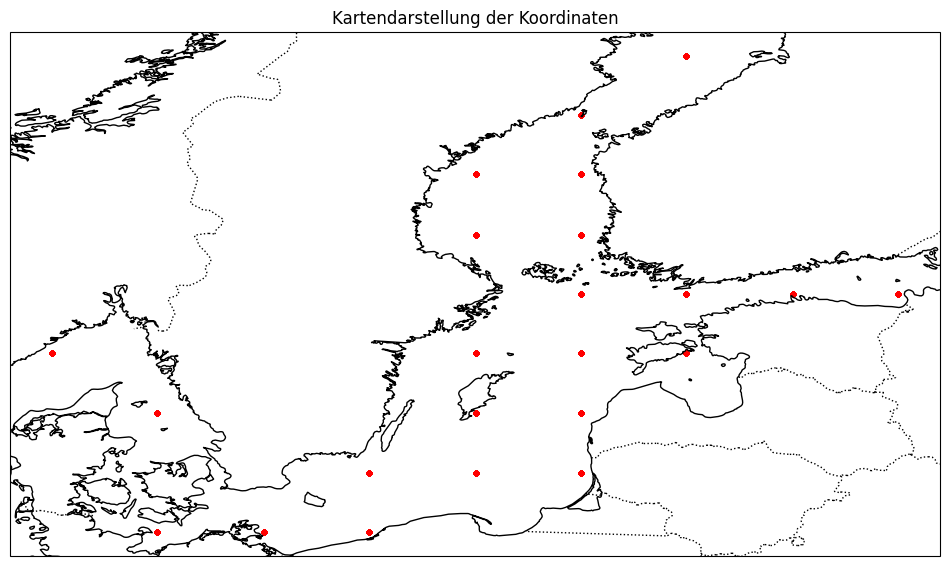

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Figure mit Kartenprojektion erstellen
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Küstenlinien und Länder hinzufügen
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Punkte plotten
ax.scatter(df_ocean['longitude'], df_ocean['latitude'], c='red', s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Achsen und Titel
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kartendarstellung der Koordinaten")

plt.show()


### Weather Data

In [10]:
# Get unique latitudes and longitudes
coordinates = sorted(set(zip(df_ocean['latitude'], df_ocean['longitude'])))
print(f'Number of unique coordinates: {len(coordinates)}')

list(coordinates)

Number of unique coordinates: 23


[(54.42494201660156, 11.430461883544922),
 (54.42494201660156, 13.791563987731934),
 (54.42494201660156, 16.124893188476562),
 (55.7415885925293, 16.124893188476562),
 (55.7415885925293, 18.48607635498047),
 (55.7415885925293, 20.819480895996094),
 (57.05823516845703, 11.430461883544922),
 (57.05823516845703, 18.48607635498047),
 (57.05823516845703, 20.819480895996094),
 (58.39154052734375, 9.097137451171875),
 (58.39154052734375, 18.48607635498047),
 (58.39154052734375, 20.819480895996094),
 (58.39154052734375, 23.15288543701172),
 (59.708187103271484, 20.819480895996094),
 (59.708187103271484, 23.15288543701172),
 (59.708187103271484, 25.514068603515625),
 (59.708187103271484, 27.84747314453125),
 (61.02483367919922, 18.48607635498047),
 (61.02483367919922, 20.819480895996094),
 (62.35814666748047, 18.48607635498047),
 (62.35814666748047, 20.819480895996094),
 (63.6747932434082, 20.819480895996094),
 (64.9912109375, 23.15288543701172)]

In [11]:
latitudes = [lat for lat, lon in coordinates]
longitudes = [lon for lat, lon in coordinates]

    
print(latitudes, longitudes)
end_date_dt = datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")

#start_str = start_date_dt.strftime("%Y-%m-%d")
end_str = end_date_dt.strftime("%Y-%m-%d")
open_meteo_weather = OpenMeteoWeather(
    latitudes=latitudes,
    longitudes=longitudes,
    start_date=START_DATE,
    end_date=end_str
)
data = open_meteo_weather.get_weather_dataframe()

[54.42494201660156, 54.42494201660156, 54.42494201660156, 55.7415885925293, 55.7415885925293, 55.7415885925293, 57.05823516845703, 57.05823516845703, 57.05823516845703, 58.39154052734375, 58.39154052734375, 58.39154052734375, 58.39154052734375, 59.708187103271484, 59.708187103271484, 59.708187103271484, 59.708187103271484, 61.02483367919922, 61.02483367919922, 62.35814666748047, 62.35814666748047, 63.6747932434082, 64.9912109375] [11.430461883544922, 13.791563987731934, 16.124893188476562, 16.124893188476562, 18.48607635498047, 20.819480895996094, 11.430461883544922, 18.48607635498047, 20.819480895996094, 9.097137451171875, 18.48607635498047, 20.819480895996094, 23.15288543701172, 20.819480895996094, 23.15288543701172, 25.514068603515625, 27.84747314453125, 18.48607635498047, 20.819480895996094, 18.48607635498047, 20.819480895996094, 20.819480895996094, 23.15288543701172]


Processing weather data: 100%|██████████| 46/46 [00:00<00:00, 235.05it/s]


In [12]:

df_weather = data.copy()
ncols = len(df_weather.columns)

# drop cols with lot of missing values
df_weather = df_weather.dropna(axis=1, thresh=0.9*len(df_weather))
df_weather = df_weather.dropna(axis=0, how="any")
df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
Index: 35926 entries, 0 to 36431
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   latitude                    35926 non-null  float64       
 1   longitude                   35926 non-null  float64       
 2   time                        35926 non-null  datetime64[ns]
 3   temperature_2m              35926 non-null  float32       
 4   relative_humidity_2m        35926 non-null  float32       
 5   dew_point_2m                35926 non-null  float32       
 6   apparent_temperature        35926 non-null  float32       
 7   precipitation               35926 non-null  float32       
 8   rain                        35926 non-null  float32       
 9   showers                     35926 non-null  float32       
 10  snowfall                    35926 non-null  float32       
 11  weather_code                35926 non-null  float32       


,latitude,longitude,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,54.424942,11.430462,2024-12-31 23:00:00,3.80,88.977997,2.15,-5.254288,0.2,0.2,0.0,0.0,51.0,1010.599976,1010.599976,100.0,100.0,51.0,100.0,0.017204,0.088631,49.953808,218.563095,68.760002
1,54.424942,11.430462,2025-01-01 00:00:00,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
2,54.424942,11.430462,2025-01-01 01:00:00,4.65,88.108688,2.85,-4.481308,0.4,0.4,0.0,0.0,51.0,1008.099976,1008.099976,100.0,100.0,100.0,100.0,0.020372,0.101490,51.350502,222.300644,68.400002
3,54.424942,11.430462,2025-01-01 02:00:00,5.05,88.456490,3.30,-4.119362,0.6,0.6,0.0,0.0,53.0,1007.200012,1007.200012,100.0,100.0,100.0,100.0,0.020272,0.101308,52.190067,224.161682,70.199997
4,54.424942,11.430462,2025-01-01 03:00:00,5.45,88.491531,3.70,-3.849421,0.4,0.4,0.0,0.0,51.0,1006.299988,1006.299988,100.0,100.0,100.0,100.0,0.021022,0.103846,53.610092,226.768631,70.919998


In [13]:
cords = set(zip(df_weather['latitude'].astype(float), df_weather['longitude'].astype(float)))
cords

{(54.42494201660156, 11.430461883544922),
 (54.42494201660156, 13.791563987731934),
 (54.42494201660156, 16.124893188476562),
 (55.7415885925293, 16.124893188476562),
 (55.7415885925293, 18.48607635498047),
 (55.7415885925293, 20.819480895996094),
 (57.05823516845703, 11.430461883544922),
 (57.05823516845703, 18.48607635498047),
 (57.05823516845703, 20.819480895996094),
 (58.39154052734375, 9.097137451171875),
 (58.39154052734375, 18.48607635498047),
 (58.39154052734375, 20.819480895996094),
 (58.39154052734375, 23.15288543701172),
 (59.708187103271484, 20.819480895996094),
 (59.708187103271484, 23.15288543701172),
 (59.708187103271484, 25.514068603515625),
 (59.708187103271484, 27.84747314453125),
 (61.02483367919922, 18.48607635498047),
 (61.02483367919922, 20.819480895996094),
 (62.35814666748047, 18.48607635498047),
 (62.35814666748047, 20.819480895996094),
 (63.6747932434082, 20.819480895996094),
 (64.9912109375, 23.15288543701172)}

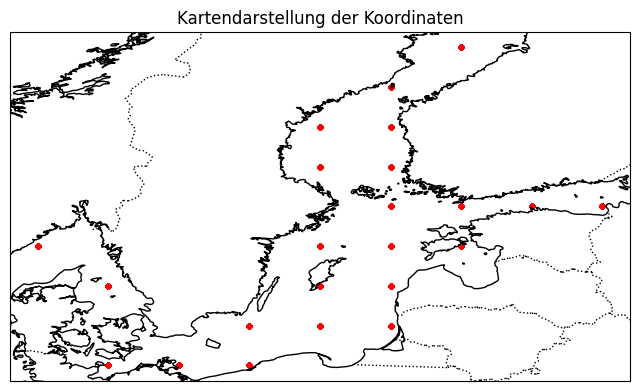

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Figure mit Kartenprojektion erstellen
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Küstenlinien und Länder hinzufügen
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Punkte plotten
ax.scatter(df_weather['longitude'], df_weather['latitude'], c='red', s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Achsen und Titel
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kartendarstellung der Koordinaten")

plt.show()

In [15]:
df_weather['latitude'].nunique(), df_weather['longitude'].nunique()
#df_weather['time'].nunique()

(9, 9)

In [16]:

df_weather = process_df(df_weather)
#df_weather.groupby(by=['time', 'latitude', 'longitude']).mean()

df_weather.rename(columns={'latitude': 'latitude_weather', 'longitude': 'longitude_weather'}, inplace=True)
df_weather.head()

,time,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2024-12-31 23:00:00,54.424942,11.430462,3.80,88.977997,2.15,-5.254288,0.2,0.2,0.0,0.0,51.0,1010.599976,1010.599976,100.0,100.0,51.0,100.0,0.017204,0.088631,49.953808,218.563095,68.760002
1,2025-01-01 00:00:00,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
2,2025-01-01 01:00:00,54.424942,11.430462,4.65,88.108688,2.85,-4.481308,0.4,0.4,0.0,0.0,51.0,1008.099976,1008.099976,100.0,100.0,100.0,100.0,0.020372,0.101490,51.350502,222.300644,68.400002
3,2025-01-01 02:00:00,54.424942,11.430462,5.05,88.456490,3.30,-4.119362,0.6,0.6,0.0,0.0,53.0,1007.200012,1007.200012,100.0,100.0,100.0,100.0,0.020272,0.101308,52.190067,224.161682,70.199997
4,2025-01-01 03:00:00,54.424942,11.430462,5.45,88.491531,3.70,-3.849421,0.4,0.4,0.0,0.0,51.0,1006.299988,1006.299988,100.0,100.0,100.0,100.0,0.021022,0.103846,53.610092,226.768631,70.919998


### Download Target Data

In [36]:
target_file = f'target_output.nc'

target_min_lon = BBOX['target_min_lon']
target_max_lon = BBOX['target_max_lon']
target_min_lat = BBOX['target_min_lat']
target_max_lat = BBOX['target_max_lat'] 

if target_file in os.listdir():
    data = xr.open_dataset(target_file)
    data = data.to_dataframe().reset_index()
else:

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=['sla'],
        minimum_longitude=target_min_lon,
        maximum_longitude=target_max_lon,
        minimum_latitude=target_min_lat,
        maximum_latitude=target_max_lat,

        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename='target_output.nc',
        delete_file=False)

    data = data.to_dataframe().reset_index()


In [37]:
df_target = process_df(data)
df_target = df_target.loc[:, ['time', 'latitude', 'longitude', 'sla']]
df_target.rename(columns={'latitude': 'latitude_target', 'longitude': 'longitude_target', 'sla': 'sla_target'}, inplace=True)
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              1572 non-null   datetime64[ns]
 1   latitude_target   1572 non-null   float32       
 2   longitude_target  1572 non-null   float32       
 3   sla_target        1572 non-null   float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 30.8 KB


In [38]:
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()
df_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              1572 non-null   datetime64[ns]
 1   latitude_target   1572 non-null   float32       
 2   longitude_target  1572 non-null   float32       
 3   sla_target        1572 non-null   float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 30.8 KB


,time,latitude_target,longitude_target,sla_target
0,2025-01-01 00:00:00,54.358276,10.152689,-0.783050
1,2025-01-01 01:00:00,54.358276,10.152689,-0.836441
2,2025-01-01 02:00:00,54.358276,10.152689,-0.888371
3,2025-01-01 03:00:00,54.358276,10.152689,-0.934821
4,2025-01-01 04:00:00,54.358276,10.152689,-0.983061


## Plot Ocean and Weather Data Coordinates and Target

In [40]:
import folium

df_map = df_weather.groupby(by=["latitude_weather", "longitude_weather"]).mean().reset_index()
# Create a folium map centered around the average lat/lon
map_center = [df_map["latitude_weather"].mean(), df_map["longitude_weather"].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Add markers
for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude_weather"], row["longitude_weather"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude_weather']}, Lon: {row['longitude_weather']}",
        icon=folium.Icon(color="blue")
    ).add_to(m)

df_map = df_ocean.groupby(by=["latitude", "longitude"]).mean().reset_index()

for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude']}, Lon: {row['longitude']}",
        icon=folium.Icon(color="red")
    ).add_to(m)

df_map = df_target.groupby(by=["latitude_target", "longitude_target"]).mean().reset_index()

for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude_target"], row["longitude_target"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude_target']}, Lon: {row['longitude_target']}",
        icon=folium.Icon(color="green")
    ).add_to(m)

m

## Merge Ocean Data and Weater Data

In [41]:
df_ocean_weather = pd.merge(df_ocean, df_weather, on=['time'], how='inner')
df_ocean_weather.info()
df_ocean_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812015 entries, 0 to 812014
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        812015 non-null  datetime64[ns]
 1   depth                       812015 non-null  float32       
 2   latitude                    812015 non-null  float32       
 3   longitude                   812015 non-null  float32       
 4   bottomT                     812015 non-null  float32       
 5   mlotst                      812015 non-null  float32       
 6   siconc                      812015 non-null  float32       
 7   sithick                     812015 non-null  float32       
 8   sla                         812015 non-null  float32       
 9   so                          812015 non-null  float32       
 10  sob                         812015 non-null  float32       
 11  thetao                      812015 non-

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
1,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,13.791564,4.75,85.047218,2.45,-2.628408,0.0,0.0,0.0,0.0,3.0,1011.299988,1011.299988,100.0,100.0,69.0,100.0,0.022970,0.128513,38.830383,223.685318,53.279999
2,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,16.124893,4.85,84.456200,2.45,-3.473537,0.1,0.1,0.0,0.0,51.0,1012.500000,1012.500000,100.0,100.0,31.0,100.0,0.026856,0.134527,45.311398,224.999893,59.399998
3,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,16.124893,5.30,88.790535,3.60,-3.681242,0.0,0.0,0.0,0.0,3.0,1006.400024,1006.400024,100.0,100.0,92.0,100.0,0.019576,0.100101,51.294945,224.573532,80.639999
4,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,18.486076,4.95,87.824806,3.10,-5.193804,0.1,0.1,0.0,0.0,51.0,1008.000000,1008.000000,100.0,100.0,42.0,100.0,0.023091,0.106110,58.612877,233.869034,82.799995


## Merge Ocean/Weather Data with Target Data

In [42]:
df_ocean_weather_target = pd.merge(df_ocean_weather, df_target, on=['time'], how='inner')
df_ocean_weather_target.info()
df_ocean_weather_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812015 entries, 0 to 812014
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        812015 non-null  datetime64[ns]
 1   depth                       812015 non-null  float32       
 2   latitude                    812015 non-null  float32       
 3   longitude                   812015 non-null  float32       
 4   bottomT                     812015 non-null  float32       
 5   mlotst                      812015 non-null  float32       
 6   siconc                      812015 non-null  float32       
 7   sithick                     812015 non-null  float32       
 8   sla                         812015 non-null  float32       
 9   so                          812015 non-null  float32       
 10  sob                         812015 non-null  float32       
 11  thetao                      812015 non-

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m,latitude_target,longitude_target,sla_target
0,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996,54.358276,10.152689,-0.78305
1,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,13.791564,4.75,85.047218,2.45,-2.628408,0.0,0.0,0.0,0.0,3.0,1011.299988,1011.299988,100.0,100.0,69.0,100.0,0.022970,0.128513,38.830383,223.685318,53.279999,54.358276,10.152689,-0.78305
2,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,16.124893,4.85,84.456200,2.45,-3.473537,0.1,0.1,0.0,0.0,51.0,1012.500000,1012.500000,100.0,100.0,31.0,100.0,0.026856,0.134527,45.311398,224.999893,59.399998,54.358276,10.152689,-0.78305
3,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,16.124893,5.30,88.790535,3.60,-3.681242,0.0,0.0,0.0,0.0,3.0,1006.400024,1006.400024,100.0,100.0,92.0,100.0,0.019576,0.100101,51.294945,224.573532,80.639999,54.358276,10.152689,-0.78305
4,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,18.486076,4.95,87.824806,3.10,-5.193804,0.1,0.1,0.0,0.0,51.0,1008.000000,1008.000000,100.0,100.0,42.0,100.0,0.023091,0.106110,58.612877,233.869034,82.799995,54.358276,10.152689,-0.78305


## Save Data for Processing

In [45]:
# Save Data as json

df_ocean_weather_target.to_json('df_ocean_weather_target.json', orient='records', lines=True, date_format='iso', date_unit='s')


In [ ]:
dd

## Transform Data to 2D-Array

### Multi-Threaded

In [34]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# Annahme: df ist dein DataFrame und enthält die Spalten 'latitude', 'longitude', 'time'
df = df_ocean_weather.copy()
# 1. Zeitsäule formatieren
df['time'] = pd.to_datetime(df['time'])
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

# Funktion zur Koordinaten-Mapping
def map_coordinates_to_grid(df):
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# Funktion zur Bilderstellung
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]
    cols = [col for col in cols if col not in ['latitude', 'longitude']]
    
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)
    
    for _, row in df.iterrows():
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]
    
    return image

# Funktion für parallele Verarbeitung eines Zeitpunkts
def process_time_point(time_point):
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)
    return time_point, np.array(image)

# Parallelisierung mit Joblib
num_cores = -1  # Nutzt alle verfügbaren CPU-Kerne
results = Parallel(n_jobs=num_cores)(
    delayed(process_time_point)(time_point) for time_point in tqdm(unique_times, desc='Processing images')
)

# Ergebnisse in ein Dictionary umwandeln
learning_data = {time_point: image for time_point, image in results}


Processing images:   2%|▏         | 32/1535 [00:44<40:20,  1.61s/it]

KeyboardInterrupt: 

In [ ]:
# Get the target column with corresponding the time
df_target = df_merged.loc[:,['time', 'sla_target']]

# Group by time to get unique timestamps
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        24 non-null     datetime64[ns]
 1   sla_target  24 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 420.0 bytes


In [ ]:
df_target = df_target.loc[:,]


df_target['time'] = pd.to_datetime(df_target['time']).dt.strftime('%Y-%m-%d %H:00:00')
print(df_target.info())
display(df_target.head(15))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   sla_target  24 non-null     float32
dtypes: float32(1), object(1)
memory usage: 420.0+ bytes
None


,time,sla_target
0,2025-03-03 23:00:00,-0.643745
1,2025-03-04 00:00:00,-0.656438
2,2025-03-04 01:00:00,-0.637845
3,2025-03-04 02:00:00,-0.603989
4,2025-03-04 03:00:00,-0.566797
5,2025-03-04 04:00:00,-0.520998
6,2025-03-04 05:00:00,-0.507128
7,2025-03-04 06:00:00,-0.477990
8,2025-03-04 07:00:00,-0.446702
9,2025-03-04 08:00:00,-0.472556


In [ ]:
df_model = pd.DataFrame([learning_data]).T.reset_index()

# rename column 0 to values
df_model.columns = ['time', 'values']

# Convert time to string
#df_model['time'] = df_model['time'].astype(str)

# Convert time to datetime
df_model['time'] = pd.to_datetime(df_model['time']).dt.strftime('%Y-%m-%d %H:00:00')
df_model.info()
df_model = pd.merge(df_model, df_target, on='time', how='inner')
df_model.info()
df_model.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    24 non-null     object
 1   values  24 non-null     object
dtypes: object(2)
memory usage: 516.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   values      24 non-null     object 
 2   sla_target  24 non-null     float32
dtypes: float32(1), object(2)
memory usage: 612.0+ bytes


,time,values,sla_target
0,2025-03-03 23:00:00,"[[[0.5016462, 3.4978201, 9.486109, 0.0, 0.0, -...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462, 3.5039175, 9.481724, 0.0, 0.0, -...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462, 3.508523, 9.502307, 0.0, 0.0, -0...",-0.637845


In [ ]:
df_model['time'].min(), df_model['time'].max()

('2025-03-03 23:00:00', '2025-03-04 22:00:00')

In [ ]:
output_filename = ouput_file_name('output', BBOX["minimum_longitude"], BBOX["maximum_longitude"])

# Save Data as json
import json
df_model.to_json(f'data/{output_filename}.json', orient='records')